In [1]:
import numpy as np
import pandas as pd

import collections
import string
import nltk
import plotly.express as px

from nltk.corpus import stopwords
from collections import defaultdict
from textblob import TextBlob

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, LSTM, SpatialDropout1D, Input, Bidirectional,Dropout

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [2]:
import json
data = pd.read_json('/Users/mahima.sharma/Downloads/Sarcasm_Headlines_Dataset_v2.json', lines=True, orient='columns', encoding='utf-8')

In [3]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data, test_size = 0.3, random_state = 101)

train_df = train_df.reset_index()
train_df = train_df.drop('index', axis = 1)

test_df = test_df.reset_index()
test_df = test_df.drop('index', axis = 1)

<b><h2> 1. Exploratory Data Analysis and Visualization</h2></b>

In [4]:
print('There are {} rows and {} columns in the training dataset'.format(train_df.shape[0], train_df.shape[1]))
print('There are {} rows and {} columns in the testing dataset'.format(test_df.shape[0], test_df.shape[1]))

There are 20033 rows and 3 columns in the training dataset
There are 8586 rows and 3 columns in the testing dataset


In [5]:
train_df.head()

,is_sarcastic,headline,article_link
0,0,'very angry badger' seizes part of 500-year-ol...,https://www.huffingtonpost.com/entry/badger-ca...
1,1,comic-con opens with traditional superhero fly...,https://entertainment.theonion.com/comic-con-o...
2,0,against divestment -- why walking away won't m...,https://www.huffingtonpost.com/entry/against-d...
3,1,area 93-year-old has death-after-life experience,https://local.theonion.com/area-93-year-old-ha...
4,1,man excited to give visiting friends the real ...,https://www.theonion.com/man-excited-to-give-v...


In [6]:
#The article link (HuffPost or The Onion) gives info on whether the title is sarcastic or not so we should drop it
train_df = train_df.drop('article_link', axis = 1) 
test_df = test_df.drop('article_link', axis = 1) 

In [7]:
train_df.groupby('is_sarcastic').describe()

headline         \
                count unique   
is_sarcastic                   
0               10495  10472   
1                9538   9490   

                                                                      
                                                            top freq  
is_sarcastic                                                          
0                                                sunday roundup   10  
1             'no way to prevent this,' says only nation whe...   10

<h4>Count of Target Variable </h4>

In [8]:
sarcastic = train_df[train_df['is_sarcastic'] == 1].shape[0]
normal = train_df[train_df['is_sarcastic'] == 0].shape[0]

<BarContainer object of 1 artists>

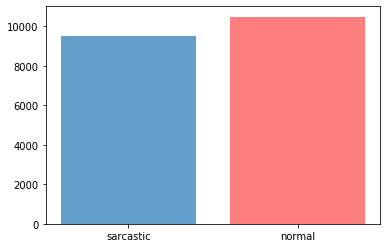

In [9]:
plt.bar('sarcastic', sarcastic, alpha = 0.7)
plt.bar('normal', normal, color = 'r', alpha = 0.5)

<h4>Length of titles </h4>

In [10]:
len_nor = train_df[train_df['is_sarcastic'] == 0]['headline'].str.len()
len_sar = train_df[train_df['is_sarcastic'] == 1]['headline'].str.len()

Text(0.5, 1.0, 'Normal Titles')

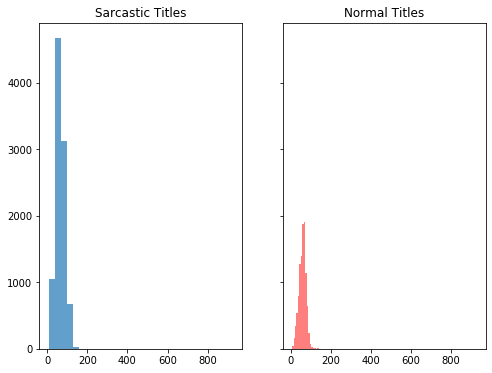

In [11]:
fig, axes = plt.subplots(1,2, figsize = (8,6), sharey = True, sharex = True)
axes[0].hist(len_sar, alpha = 0.7, bins = 30)
axes[0].set_title('Sarcastic Titles')
axes[1].hist(len_nor, color = 'r', alpha = 0.5, bins = 30)
axes[1].set_title('Normal Titles')

Sarcastic headlines have length up to around 200 whereas non sarcastic headlines have length of atmost 150

<h4>Number of words in each type of headline</h4>

In [12]:
words_sarcastic = train_df[train_df['is_sarcastic'] == 1]['headline'].str.split().map(lambda x : len(x))
words_normal = train_df[train_df['is_sarcastic'] == 0]['headline'].str.split().map(lambda x : len(x))

Text(0.5, 1.0, 'Normal Titles')

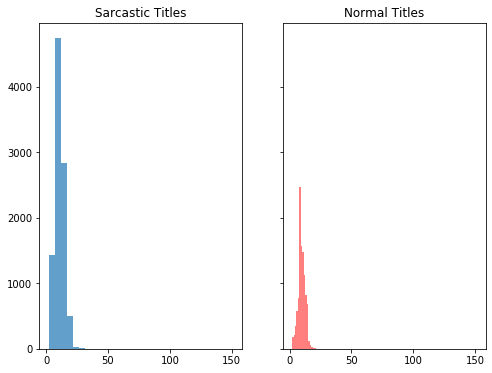

In [13]:
fig, axes = plt.subplots(1,2, figsize = (8,6), sharey = True, sharex = True)
axes[0].hist(words_sarcastic, alpha = 0.7, bins = 30)
axes[0].set_title('Sarcastic Titles')
axes[1].hist(words_normal, color = 'r', alpha = 0.5, bins = 30)
axes[1].set_title('Normal Titles')

Both types of titles have around 25 words in the title

<h4>Most common words </h4>

In [14]:
def corpus(num):
    corpus = []
    for sentence_list in train_df[train_df['is_sarcastic'] == num]['headline'].str.split():
        for word in sentence_list:
            corpus.append(word)
    return corpus

In [15]:
corpus_sar = corpus(1)
corpus_nor = corpus(0)

In [16]:
common_sar = defaultdict(int)

for word in corpus_sar:
    if word not in stopwords.words('english'):
        common_sar[word] +=1

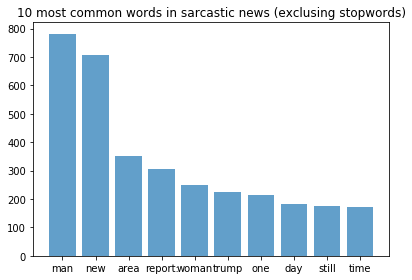

In [17]:
sar_list = sorted(common_sar.items(), key = lambda x : x[1], reverse = True)[:10]
x, y = zip(*sar_list)
plt.bar(x,y, alpha = 0.7)
plt.title('10 most common words in sarcastic news (exclusing stopwords)')
plt.tight_layout()

In [18]:
common_nor = defaultdict(int)

for word in corpus_nor:
    if word not in stopwords.words('english'):
        common_nor[word] +=1

In [19]:
nor_list = sorted(common_nor.items(), key = lambda x : x[1], reverse = True)[:10]

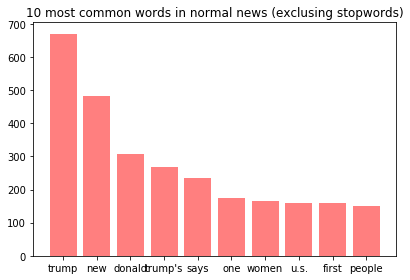

In [20]:
nor_list = sorted(common_nor.items(), key = lambda x : x[1], reverse = True)[:10]
x, y = zip(*nor_list)
plt.bar(x,y, color = 'r',alpha = 0.5)
plt.title('10 most common words in normal news (exclusing stopwords)')
plt.tight_layout()

<h4> Most common punctuation </h4>

In [21]:
punc_sar = defaultdict(int)

for word in corpus_sar:
    if word in string.punctuation:
        punc_sar[word] +=1

<BarContainer object of 3 artists>

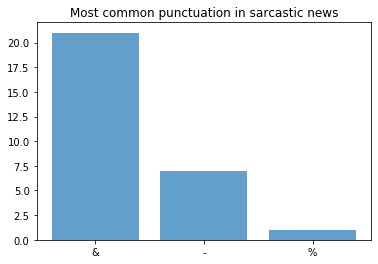

In [22]:
x,y = zip(*sorted(punc_sar.items(), key = lambda x : x[1], reverse = True))
plt.title('Most common punctuation in sarcastic news')
plt.bar(x,y, alpha = 0.7)

In [23]:
punc_nor = defaultdict(int)

for word in corpus_nor:
    if word in string.punctuation:
        punc_nor[word] +=1

<BarContainer object of 8 artists>

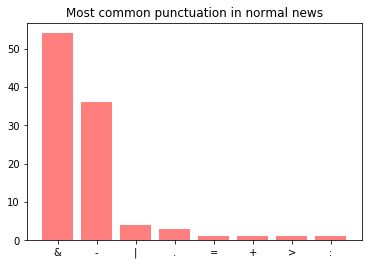

In [24]:
x,y = zip(*sorted(punc_nor.items(), key = lambda x : x[1], reverse = True))
plt.title('Most common punctuation in normal news')
plt.bar(x,y, color = 'r', alpha = 0.5)

Normal headlines utilize a wider range of punctuation

<h4> Sentiment Analysis of Headlines </h4>

In [25]:
polarity_sar = train_df[train_df['is_sarcastic'] == 1]['headline'].map(lambda text : TextBlob(text).sentiment.polarity)

Text(0.5, 1.0, 'Sentiment of sarcastic titles')

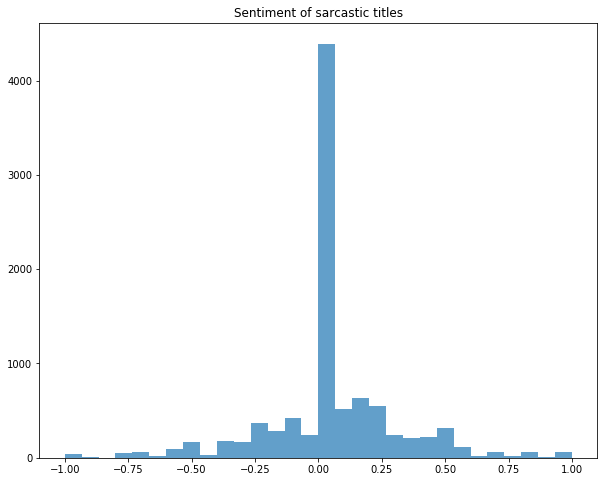

In [26]:
plt.figure(figsize = (10,8))
plt.hist(polarity_sar, bins = 30, alpha = 0.7)
plt.title('Sentiment of sarcastic titles')

In [27]:
polarity_nor = train_df[train_df['is_sarcastic'] == 0]['headline'].map(lambda text : TextBlob(text).sentiment.polarity)

Text(0.5, 1.0, 'Sentiment of normal titles')

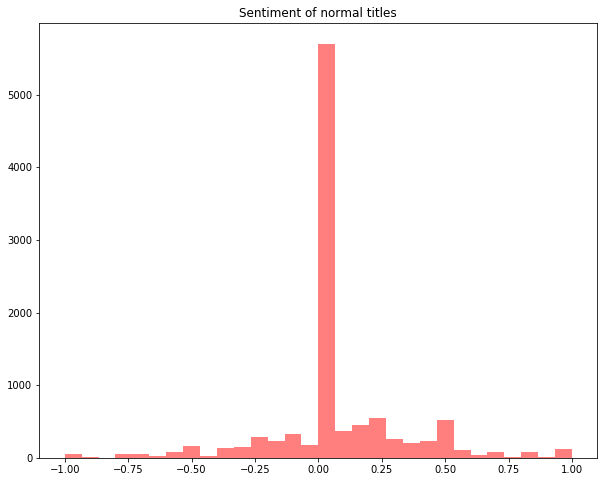

In [28]:
plt.figure(figsize = (10,8))
plt.hist(polarity_nor, bins = 30, color = 'r', alpha = 0.5)
plt.title('Sentiment of normal titles')

There is no strong negative or positive inclination in both normal and sarcastic titles 

<h2><b> 2. Data Cleaning </b></h2>

<h3>2a. Normalization and Tokenization<h3>

In [29]:
def process(sentence): 
    return [word.lower() for word in sentence.split() if word not in string.punctuation]
        

In [30]:
train_df['headline'] = train_df['headline'].apply(lambda x : process(x))
test_df['headline'] = test_df['headline'].apply(lambda x : process(x))

In [31]:
train_df['headline']

0        ['very, angry, badger', seizes, part, of, 500-...
1        [comic-con, opens, with, traditional, superher...
2        [against, divestment, --, why, walking, away, ...
3        [area, 93-year-old, has, death-after-life, exp...
4        [man, excited, to, give, visiting, friends, th...
                               ...                        
20028    [most, humiliating, experience, of, man's, lif...
20029                           [subscribing, to, success]
20030    [nom, funneled, millions, to, fight, maine, ma...
20031    [cdc, announces, americans, should, make, plan...
20032    [disturbingly, deep, voice, emanates, from, mi...
Name: headline, Length: 20033, dtype: object

<h3>2b. Stop Word Removal<h3>

In [32]:
def process(sentence_list):
    return [word for word in sentence_list if word not in stopwords.words('english')]

In [33]:
train_df['headline'] = train_df['headline'].apply(lambda x : process(x))
test_df['headline'] = test_df['headline'].apply(lambda x : process(x))

In [34]:
train_df['headline']

0        ['very, angry, badger', seizes, part, 500-year...
1        [comic-con, opens, traditional, superhero, fly...
2        [divestment, --, walking, away, make, difference]
3        [area, 93-year-old, death-after-life, experience]
4        [man, excited, give, visiting, friends, real, ...
                               ...                        
20028    [humiliating, experience, man's, life, dvd, ma...
20029                               [subscribing, success]
20030    [nom, funneled, millions, fight, maine, marria...
20031    [cdc, announces, americans, make, plans, say, ...
20032    [disturbingly, deep, voice, emanates, minnie, ...
Name: headline, Length: 20033, dtype: object

<h3> 2c. Lemmatization </h3>

In [35]:
from nltk.stem import WordNetLemmatizer 

In [36]:
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    first_char = nltk.pos_tag(word)[0][1][0].upper()
    tag_dict = {
        'J' : wordnet.ADJ,
        'N' : wordnet.NOUN,
        'V' : wordnet.VERB,
        'R' : wordnet.ADV, 
        #'P' : wordnet.ADJ
    }
    return tag_dict.get(first_char, wordnet.NOUN)

In [37]:
def lemmatization(list):
    
    return [lemmatizer.lemmatize(word, get_wordnet_pos([word])) for word in list]
        

In [38]:
lemmatizer = WordNetLemmatizer() 
train_df['headline'] = train_df['headline'].apply(lambda sentence : lemmatization(sentence))
test_df['headline'] = test_df['headline'].apply(lambda sentence : lemmatization(sentence))

In [39]:
train_df['headline']

0        ['very, angry, badger', seizes, part, 500-year...
1        [comic-con, open, traditional, superhero, flyo...
2           [divestment, --, walk, away, make, difference]
3        [area, 93-year-old, death-after-life, experience]
4        [man, excite, give, visit, friend, real, fort,...
                               ...                        
20028    [humiliate, experience, man's, life, dvd, marc...
20029                                 [subscribe, success]
20030    [nom, funnel, million, fight, maine, marriage,...
20031    [cdc, announces, american, make, plan, say, go...
20032    [disturbingly, deep, voice, emanates, minnie, ...
Name: headline, Length: 20033, dtype: object

<h2> 3. Word Cloud </h2>

<b>Wordclouds show how important a word is. More frequent words occupy greater space </b>

In [40]:
def clean_corpus(num):
    corpus = []
    for sentence_list in train_df[train_df['is_sarcastic'] == num]['headline']:
        for word in sentence_list:
            corpus.append(word)
    return corpus

In [41]:
corpus_sar = clean_corpus(1)

In [42]:
corpus_nor = clean_corpus(0)

In [43]:
len(corpus_sar)

73923

In [44]:
len(corpus_nor)

72687

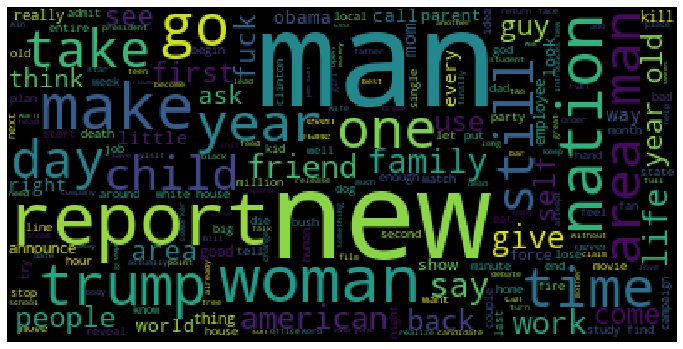

In [45]:
from wordcloud import WordCloud

plt.figure(figsize = (12,8))

word_cloud = WordCloud(background_color = 'black', max_font_size = 80).generate(" ".join(corpus_sar))

plt.imshow(word_cloud)
plt.axis('off')
plt.show()

Man is the most frequent word in sarcastic headlines

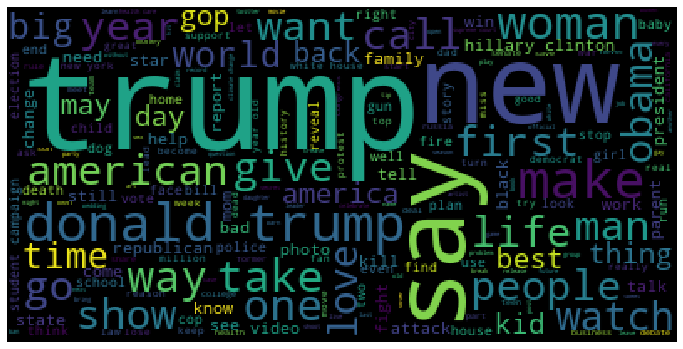

In [46]:
from wordcloud import WordCloud

plt.figure(figsize = (12,8))

word_cloud = WordCloud(background_color = 'black', max_font_size = 80).generate(" ".join(corpus_nor))

plt.imshow(word_cloud)
plt.axis('off')
plt.show()

Trump is the most frequent word in normal headlines

<h2>4. BAG OF WORDS </h2>

In [47]:
def clean_corpus_total(sentence):
    return " ".join(sentence)

In [48]:
X_train = train_df['headline'].apply(lambda sentence : clean_corpus_total(sentence)).to_numpy()

In [49]:
X_test = test_df['headline'].apply(lambda sentence : clean_corpus_total(sentence)).to_numpy()

In [50]:
y_train = train_df['is_sarcastic'].to_numpy()
y_test = test_df['is_sarcastic'].to_numpy()

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vector_train = vectorizer.fit_transform(X_train)
vector_test = vectorizer.transform(X_test)

In [52]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(vector_train,y_train)
mnb_prediction = mnb.predict(vector_test)

In [53]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, mnb_prediction))
print(classification_report(y_test, mnb_prediction))

[[3607  883]
 [ 900 3196]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      4490
           1       0.78      0.78      0.78      4096

    accuracy                           0.79      8586
   macro avg       0.79      0.79      0.79      8586
weighted avg       0.79      0.79      0.79      8586



In [54]:
mnb_prediction[345]

0

In [55]:
y_test[345]

1

In [56]:
X_test[345]

'gwyneth paltrow report news'

<h2> 5. TF-IDF </h2>

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vector_train = vectorizer.fit_transform(X_train)
vector_test = vectorizer.transform(X_test)

In [58]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(vector_train,y_train)
mnb_prediction = mnb.predict(vector_test)

In [59]:
print(confusion_matrix(y_test, mnb_prediction))
print(classification_report(y_test, mnb_prediction))

[[3767  723]
 [1064 3032]]
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      4490
           1       0.81      0.74      0.77      4096

    accuracy                           0.79      8586
   macro avg       0.79      0.79      0.79      8586
weighted avg       0.79      0.79      0.79      8586



In [60]:
mnb_prediction[345]

0

In [61]:
y_test[345]

1

<h2> 6. Word2Vec </h2>

In [62]:
X_train = pd.Series(X_train)
X_test = pd.Series(X_test)
whole = pd.concat([X_train, X_test])

In [63]:
words = []
for i in whole.values:
    words.append(i.split())
words[:5]

[["'very",
  'angry',
  "badger'",
  'seizes',
  'part',
  '500-year-old',
  'scottish',
  'castle'],
 ['comic-con', 'open', 'traditional', 'superhero', 'flyover'],
 ['divestment', '--', 'walk', 'away', 'make', 'difference'],
 ['area', '93-year-old', 'death-after-life', 'experience'],
 ['man',
  'excite',
  'give',
  'visit',
  'friend',
  'real',
  'fort',
  'wayne',
  'experience']]

In [64]:
EMBEDDING_DIM = 300

In [65]:
from gensim.models import Word2Vec

word2vec = Word2Vec(sentences = words, min_count = 1, window = 5, size = EMBEDDING_DIM)

In [66]:
word2vec.wv.most_similar(positive = ["angry"])

[('give', 0.9996919631958008),
 ('company', 0.9996898174285889),
 ('policy', 0.9996896982192993),
 ('former', 0.9996888637542725),
 ('national', 0.9996860027313232),
 ('take', 0.9996860027313232),
 ('talk', 0.9996858835220337),
 ('obama', 0.9996856451034546),
 ('news', 0.9996856451034546),
 ('john', 0.9996851086616516)]

In [67]:
word2vec.wv.most_similar(negative = ["angry"])

[('sniglets', 0.8695182204246521),
 ('fastest-rising', 0.8344316482543945),
 ('emojis', 0.7853833436965942),
 ('(book)', 0.7761165499687195),
 ("hours,'", 0.7072561979293823),
 ('nonstick', 0.6849967241287231),
 ('halcyon', 0.645877480506897),
 ('trampoline', 0.6412868499755859),
 ('that;', 0.6311743259429932),
 ('co-worker,', 0.6217560172080994)]

In [68]:
word2vec.wv.similarity('scottish', 'castle')

0.9959559

In [69]:
word2vec.wv.doesnt_match(['scottish', 'castle', 'superhero'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'scottish'

In [70]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = pad_sequences(tokenized_train, maxlen = 12)

In [71]:
pd.DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0,0,0,2163,1815,14146,6225,221,14147,4234,3018
1,0,0,0,0,0,0,0,5363,144,2517,3264,9679
2,0,0,0,0,0,0,14148,151,305,229,6,1816
3,0,0,0,0,0,0,0,0,13,6226,14149,516
4,0,0,0,2,422,27,250,83,169,9680,3857,516
...,...,...,...,...,...,...,...,...,...,...,...,...
28614,0,0,0,0,0,63,158,682,216,112,4626,1138
28615,0,0,0,0,0,0,264,1173,1594,12795,687,159
28616,0,0,0,0,0,0,0,141,63,298,341,384
28617,0,0,0,0,0,1582,1052,225,32844,269,28,3113


In [72]:
tokenizer.word_index.items()# tokenizer has found 26527 unique words than span 28619 sentences

dict_items([('new', 1), ('man', 2), ('trump', 3), ('get', 4), ('woman', 5), ('make', 6), ('say', 7), ('one', 8), ('go', 9), ('day', 10), ('take', 11), ('american', 12), ('area', 13), ('time', 14), ('donald', 15), ('like', 16), ('report:', 17), ('u.s.', 18), ('year', 19), ('first', 20), ('life', 21), ('find', 22), ("trump's", 23), ('way', 24), ('call', 25), ('show', 26), ('give', 27), ('people', 28), ('house', 29), ('still', 30), ('white', 31), ('want', 32), ('look', 33), ('thing', 34), ('back', 35), ('know', 36), ('obama', 37), ('come', 38), ('could', 39), ('family', 40), ('work', 41), ('need', 42), ('clinton', 43), ('child', 44), ('plan', 45), ('state', 46), ('watch', 47), ('school', 48), ('see', 49), ('world', 50), ('right', 51), ('use', 52), ('would', 53), ('kill', 54), ('think', 55), ('big', 56), ('love', 57), ('change', 58), ('bill', 59), ('gop', 60), ('black', 61), ('report', 62), ('mom', 63), ('really', 64), ('nation', 65), ('try', 66), ('talk', 67), ('kid', 68), ('parent', 69),

In [73]:
#each token will have a weight (from word2vec) with 100 columns 
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [74]:
len(word2vec.wv.vocab)

32844

In [75]:
embedding_vectors = get_weight_matrix(word2vec, tokenizer.word_index)

<ipython-input-73-2d8616b9fc23>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  weight_matrix[i] = model[word]


In [76]:
vocab_size = len(tokenizer.word_index) + 1

In [77]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

In [78]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=12, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [79]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 12, 300)           9853500   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 12, 256)           439296    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                55488     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 10,348,349
Trainable params: 10,348,349
Non-trainable params: 0
_________________________________________________________________


In [80]:
X_train, X_test, y_train, y_test = train_test_split(x, data['is_sarcastic'] , test_size = 0.3 , random_state = 0) 

In [81]:
y_train = pd.DataFrame(y_train).reset_index(drop = True)
y_test = pd.DataFrame(y_test).reset_index(drop = True)

In [82]:
history = model.fit(X_train, y_train, batch_size = 1024 , validation_data = (X_test,y_test) , epochs = 5)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 20033 samples, validate on 8586 samples
Epoch 1/5
20033/20033 [==============================] - 30s 1ms/step - loss: 0.7761 - acc: 0.4980 - val_loss: 0.6928 - val_acc: 0.5292
Epoch 2/5
20033/20033 [==============================] - 32s 2ms/step - loss: 0.6579 - acc: 0.6226 - val_loss: 0.7608 - val_acc: 0.4955
Epoch 3/5
20033/20033 [==============================] - 29s 1ms/step - loss: 0.4716 - acc: 0.7723 - val_loss: 0.8571 - val_acc: 0.5078
Epoch 4/5
20033/20033 [==============================] - 28s 1ms/step - loss: 0.2540 - acc: 0.8948 - val_loss: 1.2567 - val_acc: 0.5096
Epoch 5/5
20033/20033 [==============================] - 33s 2ms/step - loss: 0.1383 - acc: 0.9441 - val_loss: 1.6039 - val_acc: 0.4997


In [83]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

20033/20033 [==============================] - 17s 860us/step
Accuracy of the model on Training Data is -  97.41925597190857
8586/8586 [==============================] - 10s 1ms/step
Accuracy of the model on Testing Data is -  49.965059757232666


In [84]:
pred = model.predict_classes(X_test)
pred[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1]], dtype=int32)

In [85]:
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.53      0.50      0.51      4560
    Sarcastic       0.47      0.50      0.48      4026

     accuracy                           0.50      8586
    macro avg       0.50      0.50      0.50      8586
 weighted avg       0.50      0.50      0.50      8586



In [86]:
y_test[:10]

,is_sarcastic
0,1
1,0
2,1
3,0
4,1
5,1
6,0
7,0
8,1
9,1


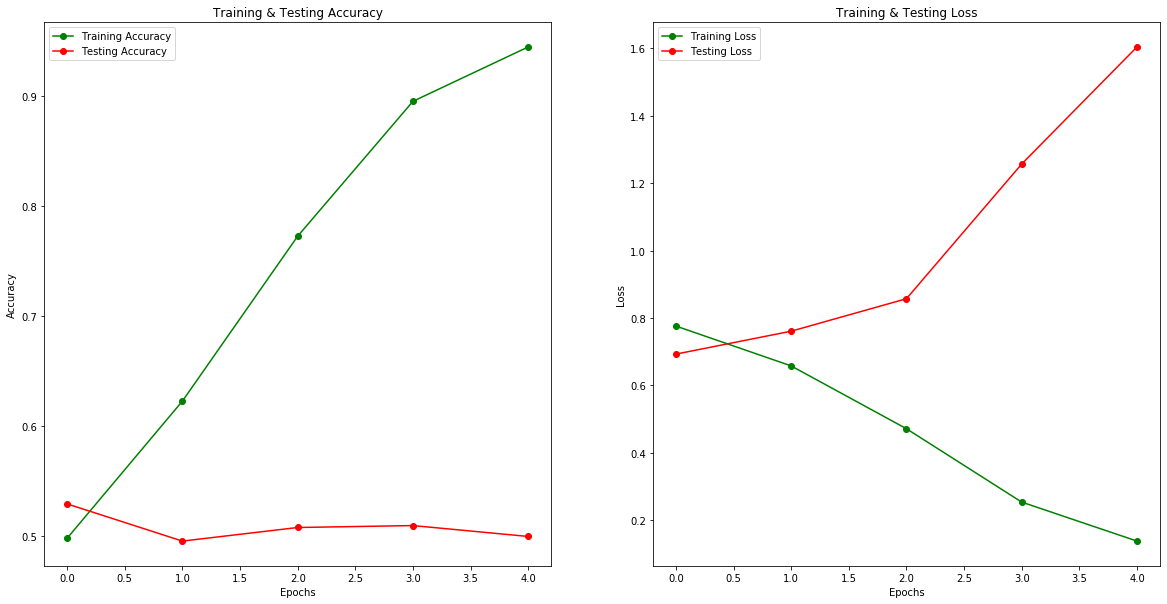

In [87]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()
